# Distributional Properties of New Parametrization of Correlation Matrices
## Marseille June 14, 2022: Lecture 2 

In [1]:
#import Pkg; Pkg.add("StatsPlots")
using Plots
using LinearAlgebra
using Plots, StatsPlots

In [6]:
function GFTstep!(G,Δx)   # the "!" is important for speed. So is "." in code below. Modifying memory
    Δx .= log.(diag(exp(G)))
    for i∈1:length(Δx)
        G[i,i] -= Δx[i]   # update diagonal elements
    end
end

GFTstep! (generic function with 1 method)

In [7]:
G = [ 0  -0.2 0.5;
     -0.2 0   0.7;
      0.5 0.7 0  ]

3×3 Matrix{Float64}:
  0.0  -0.2  0.5
 -0.2   0.0  0.7
  0.5   0.7  0.0

In [8]:
exp(G)

3×3 Matrix{Float64}:
  1.13009    -0.0395539  0.490013
 -0.0395539   1.25781    0.737104
  0.490013    0.737104   1.36956

In [9]:
Δx = diag(G)
GFTstep!(G,Δx)
exp(G)

3×3 Matrix{Float64}:
  0.993486  -0.039511  0.393902
 -0.039511   0.994763  0.560435
  0.393902   0.560435  1.01094

## Let's automate the algorithm

In [10]:
function GFT(G, ϵ::Float64 = 1e-12)
    n = size(G,1)
    δ = Inf; N = -1; Δx = ones(n,1)   # initialize
    while δ > sqrt(n)*ϵ
        GFTstep!(G,Δx)                # GFTstep updated diagonal of A, the
        δ = norm(Δx)                  # convergence is defined by δ
        N = N + 1
    end
    return Symmetric(exp(G)), N
end
C,N = GFT(G)
C

3×3 Symmetric{Float64, Matrix{Float64}}:
  1.0        -0.0406434  0.392774
 -0.0406434   1.0        0.558645
  0.392774    0.558645   1.0

In [11]:
log(C)

3×3 Symmetric{Float64, Matrix{Float64}}:
 -0.115138  -0.2        0.5
 -0.2       -0.222925   0.7
  0.5        0.7       -0.327165

# Part 2.A: Sample Correlation and its Finite Sample Properties

Suppose that $(X_i,Y_i)$ are iid with finite fourth moment, and denote $\rho=\mathrm{corr}(X,Y)$ their correlation coefficient.

Empirical correlation

$$ \hat{\rho}= 
\frac{ 
    \widehat{\mathrm{cov}}(X,Y)
    }{ 
    \sqrt{\widehat{\mathrm{var}}(X)\widehat{\mathrm{var}}(Y)}
    },
$$

is such that
$$ \sqrt{T}(\hat{\rho}-\rho) \overset{d}{\rightarrow} N(0,[1-\rho^2]^2)\qquad \text{as}\quad T\rightarrow \infty. $$
## Simulate a single correlation (Julia code)

In [31]:
using Statistics
ρ = 0.5
Z  = randn(100,1)
X  = randn(100,1)
Y  = ρ.*X +sqrt(1-ρ^2).*Z
cor(X,Y)

1×1 Matrix{Float64}:
 0.4925712517802034

## Simulate $N$ Sample Correlations

In [66]:
function ρhat(ρ,T)
    X  = randn(T)
    Y  = ρ.*X +sqrt(1-ρ^2).*randn(T)
    return cor(X,Y)
end
function ρhats(ρ,T,N)
    r = [ρhat(ρ,T) for i in 1:N]
end    
function t_ρ(ρ,T)
    ρ̂ = ρhat(ρ,T)
    return sqrt(T)*(ρ̂-ρ)/(1-ρ̂^2)
end
function tρCDF(ρ,T,N,c)
    δ = [ (t_ρ(ρ,T)<c) for i in 1:N]
    return mean(δ)
end    
    
T = 40
ρ = 0.9
N = 100000
LeftTailρ  = tρCDF(ρ,T,N,-1.64)
RightTailρ = 1- tρCDF(ρ,T,N,1.64)
(LeftTailρ,RightTailρ,LeftTailρ+RightTailρ)

(0.0151, 0.10882000000000003, 0.12392000000000003)

In [67]:
function t_ϕ(ρ,T)
    ρ̂ = ρhat(ρ,T)
    return sqrt(T)*(Fisher(ρ̂)-Fisher(ρ))
end

function tϕCDF(ρ,T,N,c)
    δ = [ (t_ϕ(ρ,T)<c) for i in 1:N]
    return mean(δ)
end    
LeftTailϕ  = tϕCDF(ρ,T,N,-1.64)
RightTailϕ = 1- tϕCDF(ρ,T,N,1.64)
(LeftTailϕ,RightTailϕ,LeftTailϕ+RightTailϕ)

(0.04815, 0.06533, 0.11348)

## Plot Empirical distribution of $\hat\rho$

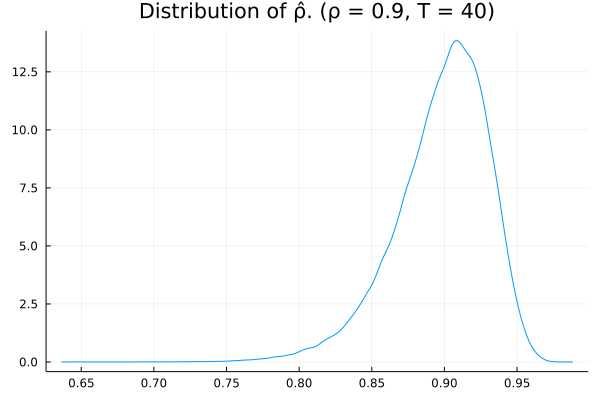

In [73]:
plot(title = "Distribution of ρ̂. (ρ = $ρ, T = $T)", legend=:none)
r = ρhats(ρ,T,N)
density!(r)

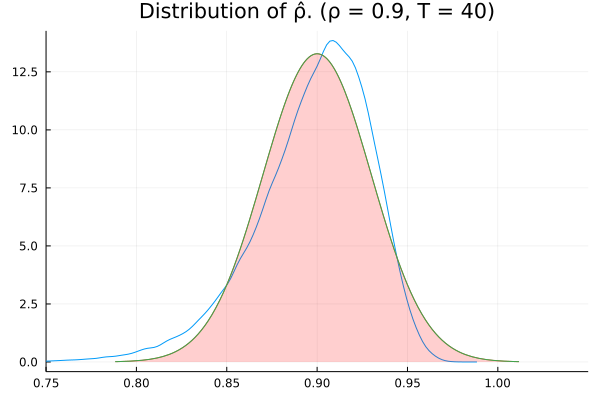

In [75]:
using Distributions
plot!(Normal(ρ,√((1-ρ^2)^2/T)), fill=(0, 0.1,:red),xlims=(0.75,1.05))

## Empirical distribution of $\hat\phi$

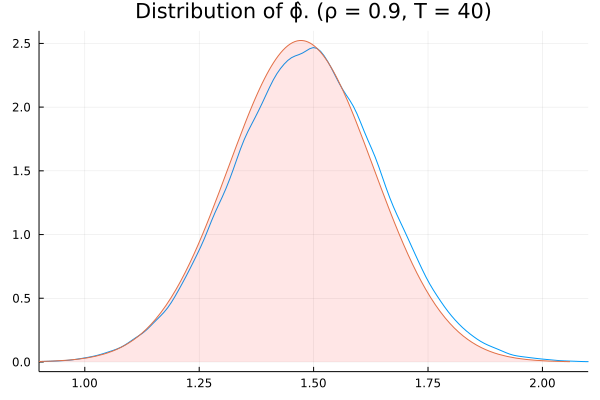

In [76]:
ϕ₀ = Fisher(ρ)
ϕ = [Fisher(r[i]) for i in 1:N] 
plot(title = "Distribution of ϕ̂. (ρ = $ρ, T = $T)", legend=:none,xlims=(0.9,2.1))
density!(ϕ)
#plot!(Normal(ϕ₀ +ρ/(2*T),√(1/T+(6-ρ^2)/(2*T^2))), fill=(0, 0.1,:red))
plot!(Normal(ϕ₀,√(1/T)), fill=(0, 0.1,:red))